<a href="https://colab.research.google.com/github/ashupk/AcademicsIITK/blob/master/main_R_script_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing relevant libraries
install.packages("igraph")
install.packages("markovchain")
install.packages("motifcluster")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘matlab’, ‘expm’, ‘RcppParallel’, ‘RcppArmadillo’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘dotCall64’, ‘gridExtra’, ‘spam’, ‘viridis’, ‘maps’, ‘mvtnorm’, ‘zoo’, ‘FNN’, ‘fields’, ‘locfit’, ‘RcppEigen’, ‘LICORS’, ‘RSpectra’




In [ ]:
# Loading the packages

library(igraph)
library(markovchain) 
library(motifcluster)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Package:  markovchain
Version:  0.8.6
Date:     2021-05-17
BugReport: https://github.com/spedygiorgio/markovchain/issues




In [ ]:
# Set seed to fix the values
set.seed(43)

In [ ]:
# Loading the Transition Matrix Data

# https://drive.google.com/file/d/1VyQLo2tV3MZzNmsPEgRjkiEJnar6uOun/view?usp=sharing
system("gdown --id 1VyQLo2tV3MZzNmsPEgRjkiEJnar6uOun")
adjm <- as.matrix(read.csv("data.csv", sep=",", row.names = 1))

In [ ]:
# Building graph from the above adjacency matrix
g <- graph_from_adjacency_matrix(adjm, weighted=TRUE, mode="directed")

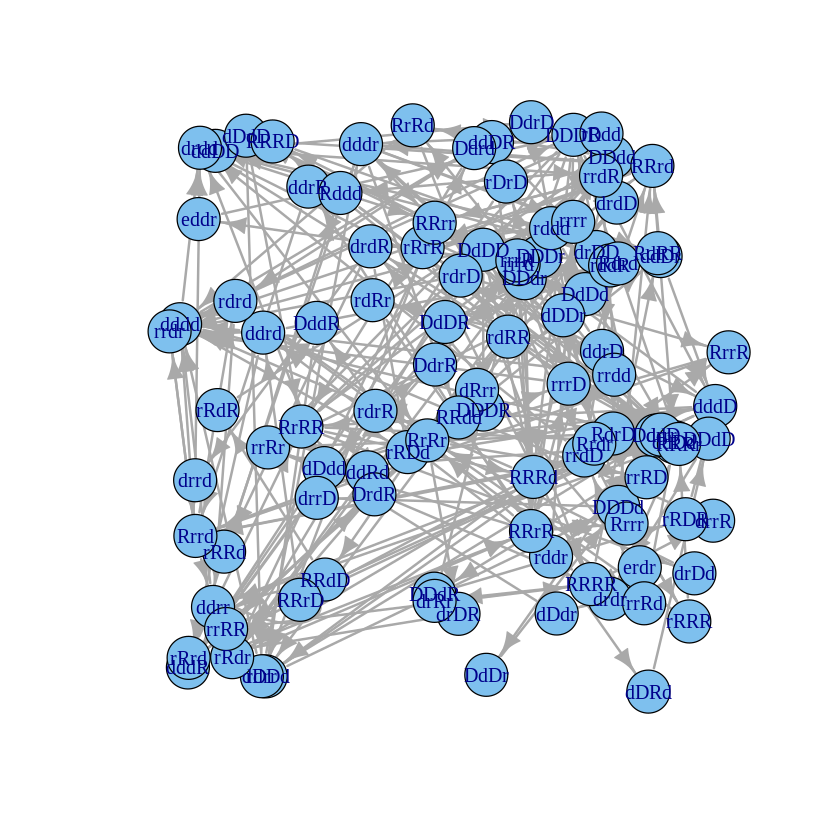

In [ ]:
plot.igraph(g, layout = layout.random, layout.par = list(), 
    labels = NULL, label.color = "darkblue", 
    label.degree = -pi/4, label.dist = 0, vertex.color = "SkyBlue2", 
    vertex.size = 15, edge.color = "darkgrey", edge.width = 2,
    edge.labels = NA, vertex.frame.color="black", rescale = FALSE)

In [ ]:
# Dimension of adjm (=104)
n <- dim(adjm)[1] 

In [ ]:
MyStates <- colnames(adjm)

In [ ]:
M <- matrix(data = adjm, byrow = FALSE, nrow = n, dimnames = list(MyStates, MyStates))

In [ ]:
# A 104 - dimensional discrete Markov Chain
mcM <- new("markovchain", transitionMatrix = M, name = "Stocks")

In [ ]:
# Ergodic? Yes
is.irreducible(mcM) # TRUE

[1] TRUE

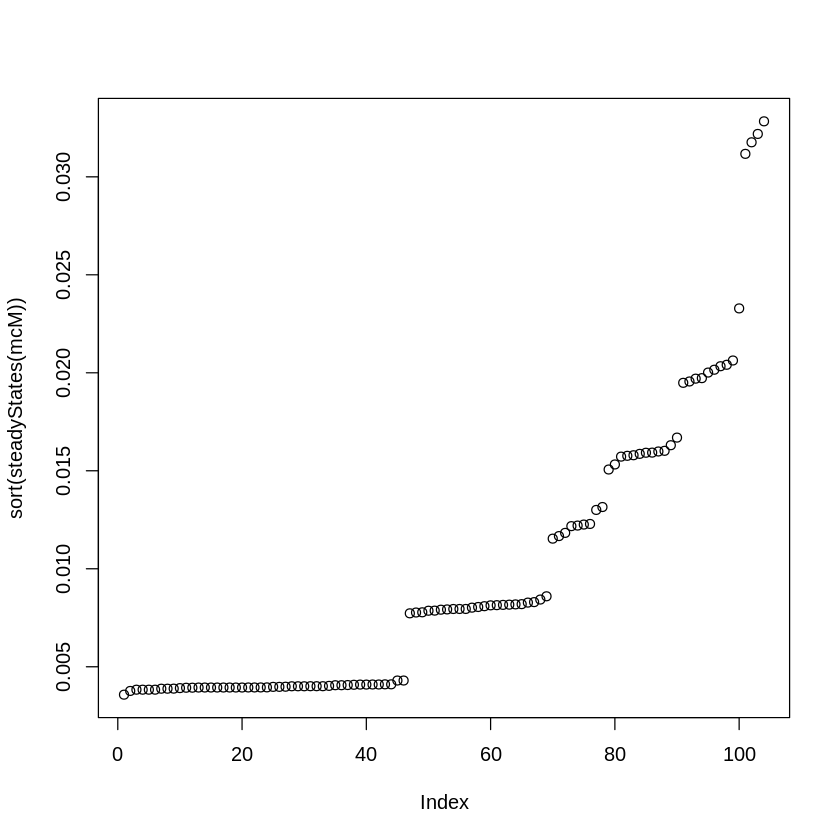

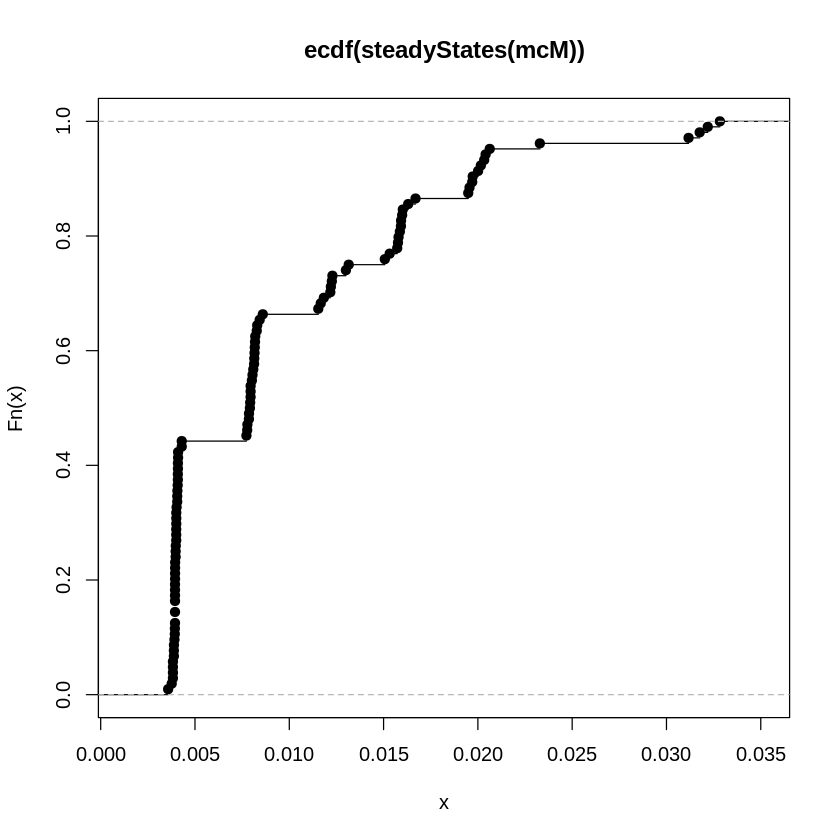

In [ ]:
# Plotting the stationary states of the markov chain
# par(mfrow=c(1,2))
plot(sort(steadyStates(mcM))) # Sorted stationary states of a markovchain object
plot(ecdf(steadyStates(mcM))) # ECDF Stationary states of a markovchain object

In [ ]:
# motif_name
motif_name="M1"

In [ ]:
# Creating the motif adjacency matrix 
madjm <- build_motif_adjacency_matrix(M,  motif_name=motif_name, motif_type="func", mam_weight_type="mean")

In [ ]:
# It should be symmetric.
isSymmetric(as.matrix(madjm))

[1] TRUE

In [ ]:
# Creating new weighted graph from the motif adjacency matrix
g <- graph_from_adjacency_matrix(madjm, weighted=TRUE)

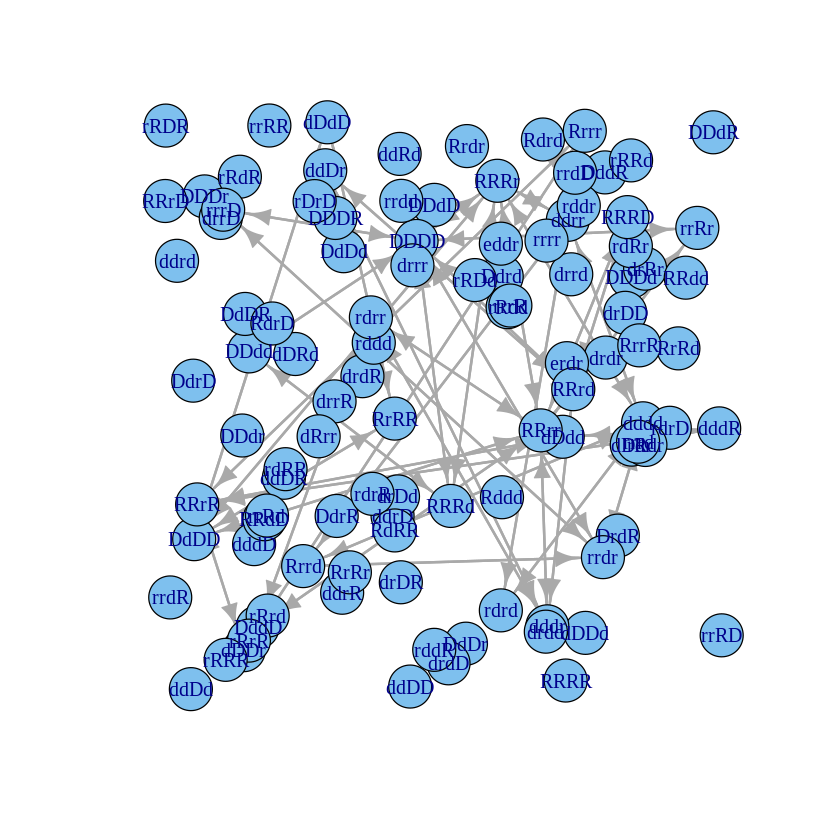

In [ ]:
# Plotting the weighted graph
plot.igraph(g, layout = layout.random, layout.par = list(), 
    labels = NULL, label.color = "darkblue", 
    label.degree = -pi/4, label.dist = 0, vertex.color = "SkyBlue2", 
    vertex.size = 15, edge.color = "darkgrey", edge.width = 2,
    edge.labels = NA, vertex.frame.color="black", rescale = FALSE)

In [ ]:
# To calculate the maximal connected component (motif) of the graph? 
cl <- components(g) 
biggest_cluster_id <- which.max(cl$csize)

In [ ]:
# ids
# Nodes from the biggest cluster (Motif)
vert_ids <- V(g)[cl$membership == biggest_cluster_id]

In [ ]:
# subgraph made from the biggest cluster nodes
ind_g <- induced_subgraph(g, vert_ids)

In [ ]:
# 4.1.2 Random-walk Laplacian
L = build_laplacian(M, type_lap = "rw")

In [ ]:
# 4.2 Laplace embedding
# consists of the eigenvalues and eigenvectors
spectrum_LE = run_laplace_embedding(M, num_eigs = n, type_lap = "rw")

In [ ]:
# 4.3 Motif embedding
spectrum_ME = run_motif_embedding(M, motif_name = motif_name, motif_type = "func", mam_weight_type = "mean", mam_method = "sparse", num_eigs = max(cl$csize),
                                  restrict = TRUE, type_lap = "rw")

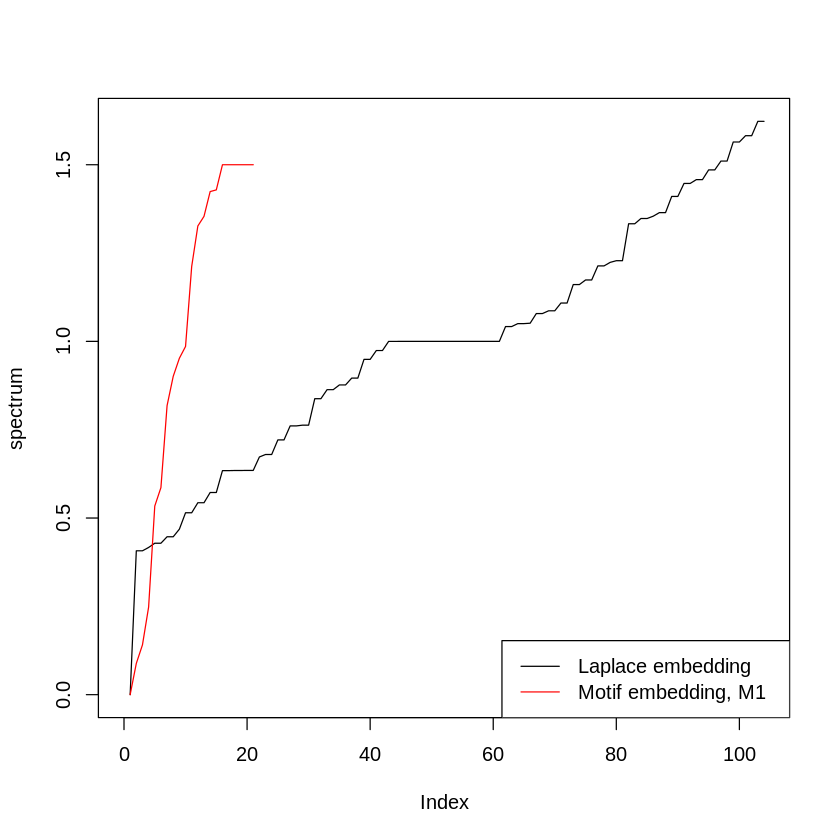

In [ ]:
# Plotting Laplace and Motif embedding
plot(spectrum_LE$vals, type = "l", ylim=c(0,max(spectrum_LE$vals)), xlim=c(0, n), ylab="spectrum")
lines(spectrum_ME$vals, type = "l", col="red")
legend("bottomright", legend = c("Laplace embedding", paste("Motif embedding", motif_name, sep=", ")), col = c("black", "red"), lty = 1)

In [ ]:
# Running motif-based clustering on the adjacency matrix of a (weighted directed) network, using a specified motif type M1
motif_cluster = run_motif_clustering(M, motif_name = "M1", motif_type = "func", mam_weight_type = "mean", mam_method = "sparse", type_lap = "rw", num_eigs = 2, num_clusts = 5)

In [ ]:
# Cluster assignment of each vertex
table(motif_cluster$clusts)


 1  2  3  4  5 
 4 10  4  1  2 

In [ ]:
# The Fruchterman-Reingold layout algorithm
coords = layout_with_fr(ind_g)

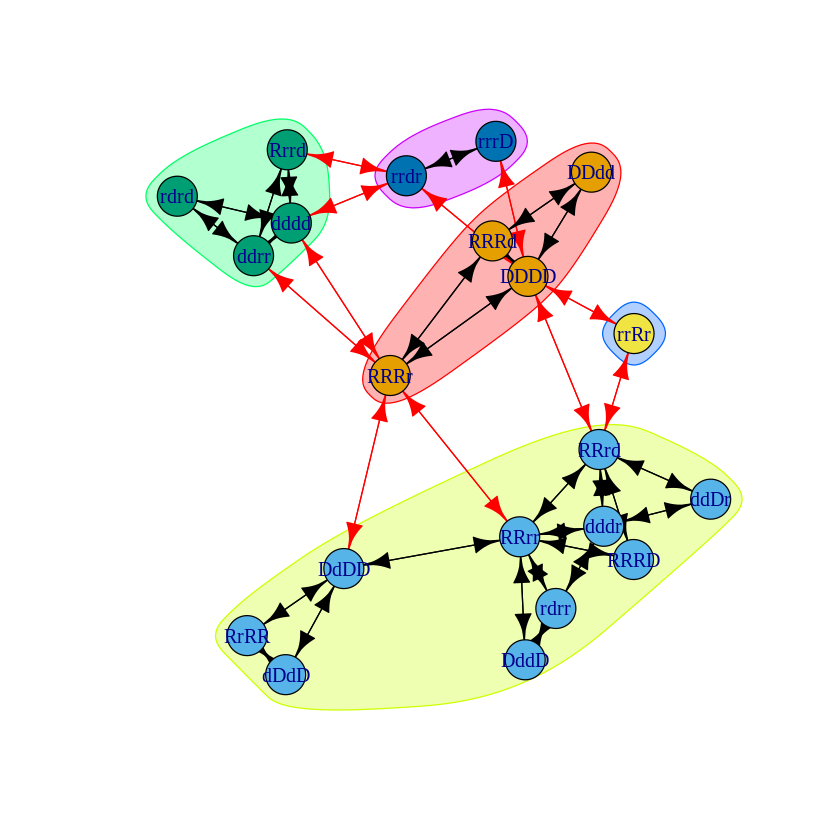

In [ ]:
# To integrate the results of community finding algorithms that are not included?
community <- make_clusters()
community$membership <- motif_cluster$clusts
plot(community, ind_g, layout = coords)

In [ ]:
# The number of intracluster and intercluster edges

n <- length(community)
d <- matrix(0, n, 1)
B <- matrix(0, n, n)

In [ ]:
# intra-cluster edges

d <- sapply(unique(membership(community)), function(i) {
  vs    <- which(membership(community) == i)
  subg1 <- induced.subgraph(ind_g, vs)  # membership id differs for each cluster
  ecount(subg1)
}
)

In [ ]:
# inter-cluster edges

cs <- data.frame(combn(unique(membership(community)), 2))
cx <- sapply(cs, function(x) {
  es <- E(ind_g)[V(ind_g)[membership(community)==x[1]] %--%
                   V(ind_g)[membership(community)==x[2]]]   
  length(es) 
}
)

In [ ]:
# sum(cx)
B[lower.tri(B, diag=FALSE)] <- cx

In [ ]:
B

0,0,0,0,0
0,0,0,0,0
4,6,0,0,0
4,0,4,0,0
0,2,2,0,0


In [ ]:
diag(B) <- d

In [ ]:
print("intracluster")
(intracluster <- sum(diag(B)))

[1] "intracluster"


[1] 52

In [ ]:
print("intercluster")
(intercluster <- ecount(ind_g)-intracluster)

[1] "intercluster"


[1] 22

In [ ]:
# Conductance
print("Conductance")
(cond <-  intercluster /(2*intracluster  + intercluster ))

[1] "Conductance"


[1] 0.1746032